# Machine learning for muon energy reconstruction in a high-granularity calorimeter
 

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
import h5py
import json
import matplotlib.pyplot as plt
import sparse
from pathlib import Path

In [23]:
from metric import compute_improvement

In [24]:
from plotting import *

## Visualization of a single muon in the calorimeter 

The calorimeter is segmented into 50 layers in $z$ and each layer is further segmented in $x$ and $y$ in $32 \times 32$ cells. This results in $51200$ channels in total. The muon enters the simulated calorimeter in the $z$ direction. The colour palette indicates logarithmic energy deposits of the muon. Black corresponds to zero, red to intermediate, and white to the maximum energy. 

In [4]:
hits, true_energy = load_tree("0.root")

In [5]:
hits_sub, true_energy_sub = restrict_energy(hits, true_energy, e_range = [1500, 1800])

plotting...


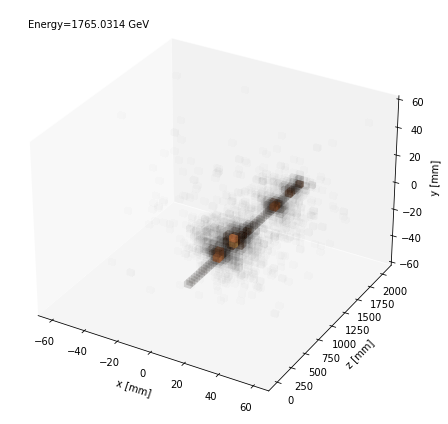

In [6]:
plot_eventdisplay(1, hits_sub, true_energy_sub, usegrid=False, save=False)

## Load high level features

In [7]:
PATH = Path("/home/centos/mount_point/data/cmu_challenge/")

In [8]:
def get_hl(file_name:str, path:Path=PATH):
    
    file = h5py.File(path/file_name, "r+")
    cont_feats = json.loads(file['meta_data/cont_feats'][()])
    hl_inputs = file['fold_0/inputs'][()]  # muon x feature numpy array
    targets = file['fold_0/targets'][()]  # muon x 1
    file.close()
    return hl_inputs, targets

In [9]:
X_train, y_train = get_hl('muon_calo_train.hdf5')
X_val, y_val = get_hl('muon_calo_val.hdf5')

## Regression with a Boosted Decision Tree with high level features

In [11]:
# create an xgboost regression model
bdt = xgb.XGBRegressor(objective='reg:squarederror')

In [12]:
bdt.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-rmse:3431.62085	validation_1-rmse:3442.57690
[1]	validation_0-rmse:2652.03589	validation_1-rmse:2664.36011
[2]	validation_0-rmse:2166.18286	validation_1-rmse:2180.58887
[3]	validation_0-rmse:1877.05359	validation_1-rmse:1893.61316
[4]	validation_0-rmse:1713.70557	validation_1-rmse:1732.47546
[5]	validation_0-rmse:1624.76074	validation_1-rmse:1646.39685
[6]	validation_0-rmse:1576.15088	validation_1-rmse:1600.81616
[7]	validation_0-rmse:1548.77441	validation_1-rmse:1576.76062
[8]	validation_0-rmse:1533.12427	validation_1-rmse:1562.65637
[9]	validation_0-rmse:1523.63269	validation_1-rmse:1555.32544
[10]	validation_0-rmse:1517.64551	validation_1-rmse:1551.34070
[11]	validation_0-rmse:1513.13599	validation_1-rmse:1548.86316
[12]	validation_0-rmse:1508.64612	validation_1-rmse:1547.30310
[13]	validation_0-rmse:1504.48950	validation_1-rmse:1545.88709
[14]	validation_0-rmse:1501.33679	validation_1-rmse:1545.74963
[15]	validation_0-rmse:1499.26538	validation_1-rmse:1545.07861
[1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
y_pred = bdt.predict(X_val) # Predictions

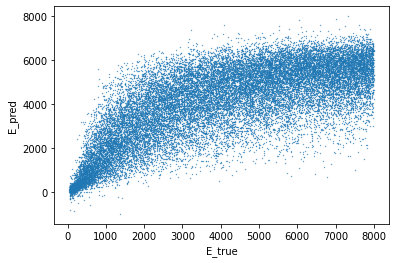

In [16]:
plt.scatter(y_val, y_pred, s=0.1)
plt.xlabel("E_true")
plt.ylabel("E_pred")
plt.show()

### Compute improvement

 Since our setup only includes a calorimeter, we assume that the resolution of a tracking measurement, performed independently by an upstream or downstream detector, scales linearly with energy, and equals 20% resolution at 1 TeV. We evaluate the resolution of both the regressor measurement and the simulated tracker measurement, along with the resolution of their weighted average. Resolution here is the fractional root median squared-error computed in bins of true energy according to:
            $$
                \text{Resolution} = \frac{\sqrt{\left(\tilde{E_p}-\tilde{E_t}\right)^2+\Delta_{68}\left[E_p\right]^2}}{\tilde{E_t}},
            $$
            where $\tilde{E_p}$ and $\tilde{E_t}$ are the median predicted and true energies in a given bin of true energy, and $\Delta_{68}\left[E_p\right]$ is the difference between the 16th and 84th percentiles of the predicted energy in that bin (the central \nth{68} percentile width). When computing the resolution on the testing data (which are generated at fixed points of true energy), $\tilde{E_t}$ is instead the true energy at a given point.

In [17]:
df = pd.DataFrame({'pred': y_pred, 'target': y_val})

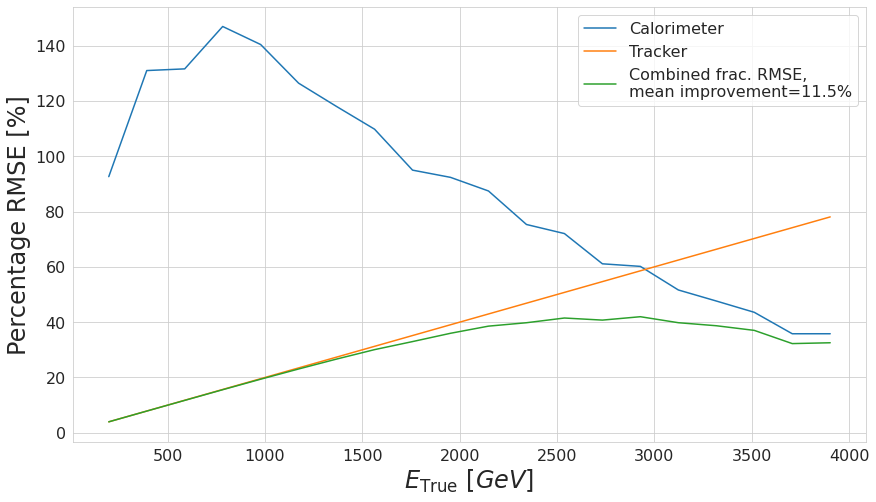

0.11506406224763119

In [18]:
compute_improvement(df)

## Create a submission

To create a submission for the challenge, predict the unlabelled 'muon_calo_test.hdf5' sample and save it to csv.

In [19]:
X_test, _ = get_hl('muon_calo_test.hdf5')

In [20]:
def create_submission(model, name="submission"):
    y_pred = model.predict(X_test)
    df = pd.DataFrame({'pred': y_pred})
    df.to_csv(name + ".csv")

In [21]:
create_submission(bdt)